# Milestone 5: Final Model + Deliverables

**Group 96**: Michelle Chang, Charlotte Cheah, Xenia Dela Cueva, Anay Patel, Miranda Shen

**Date**: May 9, 2025

---


# Table of Contents
- <a href="#intro">1. Introduction</a>
- <a href="#preprocessing">2. Preprocessing</a>
- <a href="#eda">3. EDA</a>
- <a href="#baseline">4. Baseline Model</a>
- <a href="#results">5. Baseline Model Results Analysis</a>
- <a href="#pipeline">6. Final Pipeline Setup</a>
- <a href="#qa">7. QA Final Model</a>
- <a href="#mcq">8. MCQ Final Model</a>
- <a href="#conclusion">9. Conclusion</a>

*Note: some imports can be found throughout the notebook due to challenges with dependencies and long runtimes. Some libraries required different versions of libraries, and later imports resolved this.*

<a id="intro"></a>
# 1. Introduction

In this project, we are working with the [Pira bilingual English-Portuguese dataset](https://github.com/C4AI/Pira) which is derived from a crowd-sourced project. This dataset contains Question-Answer (QA) pairs and multiple choice questions-answer (MCQA) derived from texts about the ocean, the Brazilian coastline and climate change. The aim of our project is to develop a multilingual language model that can answer questions in this topic area in both English and Portuguese, with comparable model performance on both languages. In order to ensure comparable model performance in both languages, we will leverage model fine-tuning and back-translation techniques to improve multilingual performance.

From our EDA, we found that there are a few predominant categories of questions in terms of question types (“where”, “what”, etc.) and question difficulty. Our goal is to achieve a model that generalizes well across different types of questions and is robust and versatile to new questions. We also note that there are several words that appear a lot more frequently due to the context of the dataset - these words largely relate to environmental and coastal science in and around Brazil. This is important to keep in mind during analysis as it might lead to overfitting to specific language from the training data or limitations in the model’s ability to generalize. Our decision to use back-translation was in response to this, with the aim of not only strengthening multilingual capabilities but also to diversify phrasing and reduce reliance on specific terminology used in the dataset.

In [ ]:
!pip install datasets
!pip install unidecode
!pip install deepl
!pip install evaluate rouge_score
!pip install transformers
#!pip install gensim

In [ ]:
!pip uninstall -y numpy
!pip install --no-cache-dir --force-reinstall numpy

In [ ]:
!pip install --no-cache-dir --force-reinstall pandas

In [ ]:
import os
import re
import ast
import string
import numpy as np
import pandas as pd
from collections import Counter
from random import sample
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode
import ast
import random

from transformers import (
    MarianMTModel, MarianTokenizer,
    T5Tokenizer, T5ForConditionalGeneration,
    Trainer, TrainingArguments,
    AutoTokenizer,
    pipeline
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    accuracy_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# from gensim.models import KeyedVectors
# from datasets import Dataset, DatasetDict
# import evaluate
# import gc
# import psutil
# import deepl

Our code relies heavily on several core Python libraries including numpy and pandas, as well as well-known natural language libraries such as nltk and transformers. We also have libraries such as sklearn for evaluations, as well as seaborn, wordcloud and matplotlib for visualisations. Other packages were imported for specific needs but were not used as heavily.

In [ ]:
!git clone https://github.com/C4AI/Pira.git

In [ ]:
# Load QA datasets
qa_train = pd.read_csv('Pira/Data/train.csv')
qa_val = pd.read_csv('Pira/Data/validation.csv')
qa_test = pd.read_csv('Pira/Data/test.csv')

# Load MCQA datasets
mcqa_train = pd.read_csv('Pira/MCQA/MCQA-train.csv')
mcqa_val = pd.read_csv('Pira/MCQA/MCQA-validation.csv')
mcqa_test = pd.read_csv('Pira/MCQA/MCQA-test.csv')

<a id="preprocessing"></a>
# 2. Preprocessing

In [ ]:
def drop_unnecessary_columns(df, columns_to_drop=['Unnamed: 0', 'eid_article_scopus']):
    """Remove specified columns from the dataframe."""
    return df.drop(columns=columns_to_drop)

def filter_missing_critical_fields(df, critical_fields):
    """Filter out rows with missing critical fields."""
    return df.dropna(subset=critical_fields)

def fill_missing_paraphrased_questions(df):
    """Fill NaNs in paraphrased questions with original versions."""
    df['question_en_paraphase'] = df['question_en_paraphase'].fillna(df['question_en_origin'])
    df['question_pt_paraphase'] = df['question_pt_paraphase'].fillna(df['question_pt_origin'])
    return df

def lowercase_text_columns(df, text_columns):
    """Convert all text columns to lowercase."""
    for col in text_columns:
        df[col] = df[col].str.lower()
    return df

def normalize_label_columns(df):
    """Convert label columns to integer type."""
    df['answer_in_text'] = df['answer_in_text'].astype(int)
    df['question_generic'] = df['question_generic'].astype(int)
    return df

def create_language_specific_datasets(df):
    """Create separate dataframes for English and Portuguese data."""
    df_en = df[['abstract', 'question_en_paraphase', 'answer_en_origin', 'answer_in_text']]
    df_pt = df[['abstract_translated_pt', 'question_pt_paraphase', 'answer_pt_origin', 'answer_in_text']]

    df_en.columns = ['context', 'question', 'answer', 'label']
    df_pt.columns = ['context', 'question', 'answer', 'label']

    return df_en, df_pt

def save_processed_mcqa_datasets(df_en, df_pt, en_filename, pt_filename):
    """Save English and Portuguese processed dataframes to CSV files in the current directory."""
    df_en.to_csv(en_filename, index=False)
    df_pt.to_csv(pt_filename, index=False)
    print(f"Saved: {en_filename}")
    print(f"Saved: {pt_filename}")

def preprocess_data():
    """Main function to orchestrate the entire preprocessing workflow."""
    # Define critical fields and text columns
    critical_fields = [
        'question_en_origin', 'question_pt_origin',
        'answer_en_origin', 'answer_pt_origin',
        'abstract', 'abstract_translated_pt',
        'answer_in_text', 'question_generic'
    ]

    text_cols = [
        'question_en_origin', 'question_pt_origin',
        'question_en_paraphase', 'question_pt_paraphase',
        'answer_en_origin', 'answer_pt_origin',
        'abstract', 'abstract_translated_pt',
        'pt_question_translated_to_en'
    ]

    # Process all datasets
    datasets = {'train': qa_train, 'val': qa_val, 'test': qa_test}
    processed_datasets = {}

    for name, df in datasets.items():
        # Apply preprocessing steps
        df = drop_unnecessary_columns(df)
        df = filter_missing_critical_fields(df, critical_fields)
        df = fill_missing_paraphrased_questions(df)
        df = lowercase_text_columns(df, text_cols)
        df = normalize_label_columns(df)

        # Create language-specific datasets
        df_en, df_pt = create_language_specific_datasets(df)

        # Save processed datasets
        save_processed_mcqa_datasets(
            df_en, df_pt,
            en_filename=f'processed_qa_{name}_en.csv',
            pt_filename=f'processed_qa_{name}_pt.csv'
        )

        processed_datasets[f'{name}_en'] = df_en
        processed_datasets[f'{name}_pt'] = df_pt

    return processed_datasets

if __name__ == "__main__":
    import os

    files_to_check = [
        "processed_qa_train_en.csv",
        "processed_qa_train_pt.csv",
        "processed_qa_val_en.csv",
        "processed_qa_val_pt.csv",
        "processed_qa_test_en.csv",
        "processed_qa_test_pt.csv"
    ]

    if all(os.path.exists(file) for file in files_to_check):
        print("All processed QA files already exist. Skipping preprocessing.")
    else:
        preprocess_data()

This code preprocesses the MCQA data. This code was used to generate translated files, but is commented out as we ran out of DeepL API calls. The files resulting from this have been manually loaded.

In [ ]:
# def clean_and_standardize_mcqa_data(df):
#     """Clean and standardize MCQA dataset structure."""
#     # Drop unnamed column if it exists
#     if 'Unnamed: 0' in df.columns:
#         df = df.drop(columns=['Unnamed: 0'])

#     # Ensure required columns exist
#     required_columns = ['id', 'text', 'question', 'A', 'B', 'C', 'D', 'E', 'correct', 'alternative']
#     missing_columns = [col for col in required_columns if col not in df.columns]
#     if missing_columns:
#         print(f"Warning: Missing columns: {missing_columns}")

#     # Filter out rows with missing critical fields
#     critical_fields = ['text', 'question', 'A', 'B', 'C', 'D', 'correct', 'alternative']
#     available_critical = [col for col in critical_fields if col in df.columns]
#     df = df.dropna(subset=available_critical)

#     # Lowercase text fields
#     text_columns = ['text', 'question', 'A', 'B', 'C', 'D', 'E', 'alternative']
#     for col in text_columns:
#         if col in df.columns:
#             df[col] = df[col].astype(str).str.lower()

#     return df

# def create_processed_mcqa_format(df):
#     """Create a standardized format for the MCQA task."""
#     # Create a new dataframe with standardized format
#     processed_df = pd.DataFrame()
#     processed_df['id'] = df['id'] if 'id' in df.columns else range(len(df))
#     processed_df['context'] = df['text']
#     processed_df['question'] = df['question']

#     # Format options as a list (for easier model handling)
#     processed_df['options'] = df.apply(
#         lambda row: [
#             row['A'] if pd.notna(row['A']) else '',
#             row['B'] if pd.notna(row['B']) else '',
#             row['C'] if pd.notna(row['C']) else '',
#             row['D'] if pd.notna(row['D']) else '',
#             row['E'] if pd.notna(row['E']) and 'E' in df.columns else ''
#         ], axis=1
#     )

#     # Save the correct option and alternative
#     processed_df['correct_option'] = df['correct']
#     processed_df['correct_answer_text'] = df['alternative']

#     return processed_df

# def save_processed_mcqa_datasets(processed_df, filename, output_dir="processed_mcqa"):
#     """Save processed dataframe to CSV file."""
#     os.makedirs(output_dir, exist_ok=True)
#     output_path = f"{output_dir}/{filename}"
#     processed_df.to_csv(output_path, index=False)
#     print(f"Saved processed MCQA dataset to '{output_path}'")

# translator = deepl.Translator("b88b70ad-988b-4b34-b87f-12b61578beb2:fx")

# def translate_questions_to_pt(questions, chunk_size=50):
#     # Portuguese translations for the English MCQs
#     translations = []
#     for i in range(0, len(questions), chunk_size):
#         batch = questions[i : i + chunk_size]
#         result = translator.translate_text(batch, target_lang="PT-BR")
#         translations.extend([r.text for r in result])
#     return translations

# def preprocess_mcqa_data():
#     """Main function to orchestrate the entire MCQA preprocessing workflow."""

#     datasets = {
#         'train': mcqa_train,
#         'validation': mcqa_val,
#         'test': mcqa_test
#     }

#     processed_datasets = {}

#     for name, df in datasets.items():
#         print(f"Processing {name} dataset...")

#         # Clean and standardize data
#         cleaned_df = clean_and_standardize_mcqa_data(df)

#         # Create processed format
#         processed_df = create_processed_mcqa_format(cleaned_df)

#         # Create PT translations column
#         processed_df["question_pt_deepl"] = translate_questions_to_pt(processed_df["question"].tolist())

#          # Save processed dataset
#         save_processed_mcqa_datasets(processed_df, f"processed_mcqa_{name}.csv")

#         processed_datasets[name] = processed_df

#     print("MCQA preprocessing complete for all datasets.")
#     return processed_datasets

# if __name__ == "__main__":
#     import os

#     files_to_check = [
#         "processed_mcqa_train.csv",
#         "processed_mcqa_validation.csv",
#         "processed_mcqa_test.csv"
#     ]

#     if all(os.path.exists(file) for file in files_to_check):
#         print("Processed MCQA datasets already exist in current directory. Skipping preprocessing.")
#     else:
#         preprocess_mcqa_data()

In [ ]:
mcqa_train = pd.read_csv("processed_mcqa_train.csv")
mcqa_val   = pd.read_csv("processed_mcqa_validation.csv")
mcqa_test  = pd.read_csv("processed_mcqa_test.csv")

In [ ]:
mcqa_train["options"] = mcqa_train["options"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Replace with ['a', 'b', 'c', 'd', 'e'] if the list has exactly 5 options
mcqa_train["options"] = mcqa_train["options"].apply(lambda x: ['a', 'b', 'c', 'd', 'e'] if isinstance(x, list) and len(x) == 5 else x)

mcqa_test["options"] = mcqa_test["options"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Replace with ['a', 'b', 'c', 'd', 'e'] if the list has exactly 5 options
mcqa_test["options"] = mcqa_test["options"].apply(lambda x: ['a', 'b', 'c', 'd', 'e'] if isinstance(x, list) and len(x) == 5 else x)

mcqa_val["options"] = mcqa_val["options"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Replace with ['a', 'b', 'c', 'd', 'e'] if the list has exactly 5 options
mcqa_val["options"] = mcqa_val["options"].apply(lambda x: ['a', 'b', 'c', 'd', 'e'] if isinstance(x, list) and len(x) == 5 else x)

Then, we create the initial tokenizer.

In [ ]:
MODEL_NAME = "bert-base-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [ ]:
from datasets import Dataset, DatasetDict, load_dataset

def tokenize_qa(example):
    return tokenizer(
        example["context"],
        example["question"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

def load_and_tokenize_qa(split_name):
    df = pd.read_csv(f"processed_qa_{split_name}_en.csv")
    dataset = Dataset.from_pandas(df)
    return dataset.map(tokenize_qa, batched=True, batch_size=BATCH_SIZE)

def load_and_tokenize_qa_pt(split_name):
    df = pd.read_csv(f"processed_qa_{split_name}_pt.csv")
    dataset = Dataset.from_pandas(df)
    return dataset.map(tokenize_qa, batched=True, batch_size=BATCH_SIZE)

qa_datasets = DatasetDict({
    "train": load_and_tokenize_qa("train"),
    "validation": load_and_tokenize_qa("val"),
    "test": load_and_tokenize_qa("test")
})

pt_qa_datasets = DatasetDict({
    "train": load_and_tokenize_qa_pt("train"),
    "validation": load_and_tokenize_qa_pt("val"),
    "test": load_and_tokenize_qa_pt("test")
})

In [ ]:
def tokenize_mcqa(batch):
    full_inputs = [
        f"{c} [SEP] {q} [SEP] {o}"
        for c, q, o in zip(batch["context"], batch["question"], batch["option"])
    ]
    return tokenizer(
        full_inputs,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

def expand_and_tokenize_mcqa(df):
    df["options"] = df["options"].apply(lambda x: eval(x) if isinstance(x, str) else x)

    expanded_rows = []
    for _, row in df.iterrows():
        for option in row["options"]:
            expanded_rows.append({
                "context": row["context"],
                "question": row["question"],
                "option": option,
                "label": int(option == row["correct_answer_text"]),
                "id": row.get("id", None)
            })

    expanded_df = pd.DataFrame(expanded_rows)
    dataset = Dataset.from_pandas(expanded_df)
    return dataset.map(tokenize_mcqa, batched=True, batch_size=BATCH_SIZE)


def expand_and_tokenize_mcqa_pt(df):
    df["options"] = df["options"].apply(lambda x: eval(x) if isinstance(x, str) else x)

    expanded_rows = []
    for _, row in df.iterrows():
        for option in row["options"]:
            expanded_rows.append({
                "context": row["context"],
                "question": row["question_pt_deepl"],
                "option": option,
                "label": int(option == row["correct_answer_text"]),
                "id": row.get("id", None)
            })

    expanded_df = pd.DataFrame(expanded_rows)
    dataset = Dataset.from_pandas(expanded_df)
    return dataset.map(tokenize_mcqa, batched=True, batch_size=BATCH_SIZE)

mcqa_datasets = DatasetDict({
    "train": expand_and_tokenize_mcqa(mcqa_train),
    "validation": expand_and_tokenize_mcqa(mcqa_val),
    "test": expand_and_tokenize_mcqa(mcqa_test)
})

mcqa_pt_test_dataset = expand_and_tokenize_mcqa_pt(mcqa_test)
print(mcqa_pt_test_dataset[0])

In [ ]:
# Load processed English datasets
qa_en_train = pd.read_csv("processed_qa_train_en.csv")
qa_en_val   = pd.read_csv("processed_qa_val_en.csv")
qa_en_test  = pd.read_csv("processed_qa_test_en.csv")
qa_en_all = pd.concat([qa_en_train, qa_en_val, qa_en_test], ignore_index=True)

# Load processed Portuguese datasets
qa_pt_train = pd.read_csv("processed_qa_train_pt.csv")
qa_pt_val   = pd.read_csv("processed_qa_val_pt.csv")
qa_pt_test  = pd.read_csv("processed_qa_test_pt.csv")
qa_pt_all = pd.concat([qa_pt_train, qa_pt_val, qa_pt_test], ignore_index=True)

<a id="eda"></a>
# 3. EDA

In [ ]:
# Bar plot of question types
plt.figure(figsize=(8, 4))
sns.countplot(data=qa_train, x='question_type')
plt.xticks(rotation=45)
plt.title("Distribution of Question Types")
plt.show()

# Bar plot of answer difficulty (if filled)
plt.figure(figsize=(6, 4))
sns.histplot(qa_train['answer_difficulty'].dropna(), bins=5, discrete=True)
plt.title("Distribution of Answer Difficulty")
plt.show()

Our project is centered around the question-answer format, including multiple choice questions and short answer questions, in a multilingual setting, specifically English and Portuguese. Given that our goal is to train a model that can achieve a high accuracy in answering questions, it is important to dissect our training data to identify any potential biases that can influence our model in unintended ways.

The first analysis that we decided would be of utmost importance was the question type (the classic who, what, when, where, why, and how). Question types can differ in complexity significantly. For example, intuitively, “what” would be an easier type of question to answer than “why”. Our dataset has these question types labeled, so understanding the distribution can help us identify model pain points. Our dataset overwhelmingly comprises of “what” questions, followed distantly by “how”. This does indicate a class imbalance. This is a challenging issue to address because questions of different types are innately looking for different answers. Oversampling the minority classes would not be viable because questions are unique, so it would be no different than just duplicating the same question over and over again, which does not have a purpose. Undersampling the majority class is an option, but we could lose a lot of questions in the majority class because of the magnitude of the difference in class counts. This leaves us with a couple of options. We could just train a model agnostic to question type, which would decrease our ability to assess model performance at a more granular level, or we can train separate models based on question type. The latter might be problematic for the classes with less data but does allow for more detail in our analysis.

Similar to question type, we also have data for question difficulty. The reasoning for looking into this is along the same lines. We will be interested in how our model performs on simple questions compared to difficult questions. We would expect the model to perform better on the simple questions, but if this is not the case, there would be a cause for concern. The class imbalance is far less egregious for this case, but question difficulty of 1 (simplest) is the majority class, and 5 (hardest) is the minority class. One option would be to train our model on combinations of question type and difficulty, but this could spread the data too thin. One compromise could be to just pick one of the two splits and go from there, or we can stay completely agnostic.

In [ ]:
# Combine all questions into raw text
qa_text = ' '.join(qa_train['question_en_origin'].dropna().astype(str).tolist() +
                   qa_val['question_en_origin'].dropna().astype(str).tolist() +
                   qa_test['question_en_origin'].dropna().astype(str).tolist())

mcqa_text = ' '.join(mcqa_train['question'].dropna().astype(str).tolist() +
                     mcqa_val['question'].dropna().astype(str).tolist() +
                     mcqa_test['question'].dropna().astype(str).tolist())

# Function to preprocess text
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    stopwords = set(STOPWORDS)
    words = [word for word in text.split() if word not in stopwords and word.isalpha()]
    return ' '.join(words)

# Clean the texts
qa_text_clean = clean_text(qa_text)
mcqa_text_clean = clean_text(mcqa_text)

def dark_blue_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(10, 25)  # Low lightness = dark

qa_wordcloud = WordCloud(width=800, height=400, background_color='white',
                         color_func=dark_blue_func).generate(qa_text_clean)

# Generate word clouds
qa_wordcloud = WordCloud(width=800, height=400, background_color='white',
                         color_func=dark_blue_func).generate(qa_text_clean)
mcqa_wordcloud = WordCloud(width=800, height=400, background_color='white',
                           color_func=dark_blue_func).generate(mcqa_text_clean)

# Plot side-by-side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(qa_wordcloud, interpolation='bilinear')
plt.title("QA Dataset (Cleaned) - Word Cloud")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mcqa_wordcloud, interpolation='bilinear')
plt.title("MCQA Dataset (Cleaned) - Word Cloud")
plt.axis('off')

plt.tight_layout()
plt.show()

We then created word clouds to visualize the content and predominant themes of our data. We see “Brazil” and “Petrobras” as two of the most common words. Along with other words related to water, oil, and the coast, we can see a clear theme of environmental, marine, and petroleum, centered around Brazilian coastlines. This gives us important context about the scope of our data. Our model will be most knowledgeable about questions that are highly relevant to these themes and may struggle with more vague or unrelated questions. We would expect the model to perform poorly on questions completely outside this scope unless adequate context is included. An important note is that these word clouds were created after removing stop words in order to narrow our focus to descriptive words. This analysis does not necessarily constitute any modeling modifications, but it does give us another angle to assess model performance from. How does our model perform on questions that include very common words? Does the amount of data strengthen the performance or dilute the context? These questions could be interesting to look into once we settle on the final model.

In [ ]:
def add_metrics(df, text_column="question"):
    df["char_length"] = df[text_column].astype(str).apply(len)
    df["word_count"] = df[text_column].astype(str).apply(lambda x: len(x.split()))
    df["token_count"] = df[text_column].astype(str).apply(lambda x: len(tokenizer.tokenize(x)))
    return df

# 1) Compute metrics on the PT MCQA questions column
mcqa_train_en = add_metrics(mcqa_train.copy(), text_column="question")
mcqa_train_pt = add_metrics(mcqa_train.copy(), text_column="question_pt_deepl")

qa_en_train = add_metrics(qa_en_train, text_column="question")
qa_pt_train = add_metrics(qa_pt_train, text_column="question")

# the three metrics and colors stay the same
metrics = [
    ("char_length", "Character Length"),
    ("word_count",  "Word Count"),
    ("token_count", "Token Count"),
]
colors = ["red", "green", "blue"]

# Define the two groups: MCQA (EN/PT) and QA (EN/PT)
groups = [
    (
        [(mcqa_train_en, "MCQA Train (EN)"),
         (mcqa_train_pt, "MCQA Train (PT)")],
        "MCQA Question Distributions"
    ),
    (
        [(qa_en_train,   "Short Answer QA Train (EN)"),
         (qa_pt_train,   "Short Answer QA Train (PT)")],
        "Short-Answer QA Distributions"
    ),
]

for data_list, fig_title in groups:
    # 1) compute per-group global_limits
    global_limits = {}
    for metric, _ in metrics:
        all_vals = np.concatenate([df[metric].values for df, _ in data_list])
        x_min, x_max = all_vals.min(), all_vals.max()
        bins = np.linspace(x_min, x_max, 31)
        max_freq = max(
            np.histogram(df[metric], bins=bins)[0].max()
            for df, _ in data_list
        )
        global_limits[metric] = (x_min, x_max, max_freq, bins)

    # 2) make a 2×3 figure
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    fig.suptitle(fig_title, fontsize=14)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # 3) draw the histograms
    for row_idx, (df, title) in enumerate(data_list):
        for col_idx, (metric, metric_title) in enumerate(metrics):
            ax = axes[row_idx, col_idx]
            x_min, x_max, max_freq, bins = global_limits[metric]

            ax.hist(df[metric], bins=bins,
                    color=colors[col_idx], edgecolor="black")
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(0, max_freq * 1.1)

            ax.set_title(f"{title}\n{metric_title}", fontsize=10)
            ax.set_xlabel(metric_title)
            ax.set_ylabel("Frequency")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

The next few quantities we were interested in measuring related to the length of the questions. In particular, this included the character length, word count, and token count. We wanted to compare these across our datasets: English MCQA, Portuguese MCQA (we used DeepL to translate the English to Portuguese), English QA, and Portuguese QA. Starting with the histograms for the MCQA, we can observe quite similar distributions of character length and word count for English and Portuguese, however, the token count distributions tell a different story. Most notably, the Portuguese MCQA token count distribution shows a much more distinct right-skewness, as well as a higher overall distribution center (around 25-30 compared to 15-20 for English). This is an interesting result because tokens are what is used in our language models. This result could be because of tokenization compatibility discrepancies across languages. We do not hypothesize that this will negatively impact our model, but it is worth taking note of. The short answer questions show a similar story, with very similar character length and word count distributions, but noticeably different token count distributions. Once again, the Portuguese data has a higher mode (around 20-30 compared to 15-20 for English) and a more pronounced right-skewness. Since this pattern is consistent across question structures, we believe this is simply due to the nature of the languages. If we observe significant differences across languages in our validation assessment, this could be something to reference back to.

In [ ]:
# Calculate and print the number of answerable and unanswerable questions.
# Turned it to(1 = answerable 0 = unanswerable).
answer_counts = qa_en_all['label'].value_counts()
print("Answer Count (English):")
print(answer_counts)

# Calculate and print the number of answerable and unanswerable questions.
# Here, the column 'label' indicates answerability (1 = answerable, 0 = unanswerable).
answer_counts_pt = qa_pt_all['label'].value_counts()
print("Answer Counts (Portuguese):")
print(answer_counts_pt)

In [ ]:
total = answer_counts.sum()
percentages = (answer_counts / total * 100).round(1)

plt.figure(figsize=(6, 4))
ax = answer_counts.sort_index().plot(kind='bar', color=['red', 'green'])
plt.title("Distribution of Answerable vs Unanswerable Questions")
plt.xlabel("Answerability Indicator (0 = unanswerable, 1 = answerable)")
plt.ylabel("Number of Questions")
plt.xticks(ticks=[0, 1], labels=["Unanswerable (0)", "Answerable (1)"], rotation=0)
for i, count in enumerate(answer_counts.sort_index()):
    plt.text(i, count + total * 0.01, f'{percentages[i]}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

The final class we deemed important was answerability. We compared the counts of unanswerable versus answerable questions in the QA sets. We found that 95.5% of questions were answerable, while 4.5% were not. This is again an interesting case of class imbalance, one where it is not clear whether it is concerning or not. As we mentioned earlier, the scope of this project is fairly specific (environment, marine ecosystems, oil, etc.), so we could reasonably expect questions to be related to these fields. On the contrary, it is possible that unrelated questions were thrown into the pool to see whether the models hallucinate and try to produce an answer even though they do not have the appropriate context. These “bait” questions theoretically make sense to include for that purpose, but it is also possible that the models actually could not produce an answer for questions that they should have been able to answer. We could either choose to not consider the “unanswerable” questions, or we could include them and see what our model produces for those questions. The latter seems like a more well-rounded approach that could also handle new questions, giving them a label as an option in case the question truly is unrelated to the fields we are working with. Our current plan is to include all these questions and remain agnostic to these classes.

<a id="baseline"></a>
# 4. Baseline Model

For the baseline model, we selected a pre-trained bert-base-uncased model fine-tuned as a binary classifier (num_labels=2). This choice reflects a balance between simplicity, interpretability, and relevance: BERT is a widely adopted architecture for natural language understanding tasks and serves as a strong benchmark. Although simpler models like logistic regression could be faster, they would not realistically handle the complexity of multiple-choice question answering (MCQA) or QA tasks.


In [ ]:
from transformers import AutoModelForSequenceClassification

baseline_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

In [ ]:
!pip install evaluate

The training process involved some preprocessing: questions, context passages, and options were tokenized using the default BERT tokenizer, padded and truncated to a maximum sequence length (default by the tokenizer). Each QA or MCQA sample was expanded and labeled appropriately. The model was fine-tuned for one epoch with a learning rate of 2e-5, a batch size of 8, and no weight decay. Training was configured to minimize external logging and evaluation happened once per epoch. The evaluation metric was accuracy, computed by mapping the maximum logit prediction to the true label. Huggingface’s Trainer class was used for simple and robust model management.

In [ ]:
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

import os
os.environ["WANDB_DISABLED"] = "true"

from transformers.utils import logging
logging.set_verbosity_error()

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.0,
    logging_dir="./logs"
)

In [ ]:
trainer = Trainer(
    model=baseline_model,
    args=training_args,
    train_dataset=mcqa_datasets["train"],
    eval_dataset=mcqa_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Our initial test results reflect a pretty high evaluation accuracy of 0.8 on both the English and Portuguese MCQA datasets. However, upon closer inspection, we realized that this is because the model is predicting all the options as incorrect. Since there are 5 answer choices for each question, and only one being the correct one, the model is hence able to achieve 80% accuracy by labeling all the options a incorrect (0). As such, this is not an informative model as our goal is to predict the right answer, leading us to explore other modelling strategies to combat this issue.

In [ ]:
trainer.evaluate(mcqa_datasets["test"])

In [ ]:
trainer.evaluate(eval_dataset=mcqa_pt_test_dataset)

We then went on to tokenize our QA dataset to evaluate the performance of this simple Bert model on QA predictions.

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer

qa_en_train = Dataset.from_pandas(qa_en_train.reset_index(drop=True))
qa_en_val = Dataset.from_pandas(qa_en_val.reset_index(drop=True))

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(
        examples["question"],
        examples["context"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

qa_en_train = qa_en_train.map(tokenize_function, batched=True)
qa_en_val = qa_en_val.map(tokenize_function, batched=True)



In [ ]:
qa_en_train = qa_en_train.remove_columns(["context", "question", "answer"])
qa_en_val = qa_en_val.remove_columns(["context", "question", "answer"])


In [ ]:
print(qa_en_train.column_names)
print(qa_en_val.column_names)


In [ ]:
qa_en_train = qa_en_train.rename_column("label", "labels")
qa_en_val = qa_en_val.rename_column("label", "labels")

In [ ]:
import evaluate
import numpy as np

exact_match = evaluate.load("exact_match")
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Convert to strings for exact match and ROUGE
    # Ensure the conversion keeps full text, not just IDs
    preds_str = [str(p) for p in predictions]
    labels_str = [str(l) for l in labels]

    em = exact_match.compute(predictions=preds_str, references=labels_str)["exact_match"]

    rouge_scores = rouge.compute(predictions=preds_str, references=labels_str, use_stemmer=True)
    rouge_l_fmeasure = rouge_scores["rougeL"]

    return {
        "exact_match": em,
        "rouge_L": (1- rouge_l_fmeasure)*2,
    }


In [ ]:


trainer2 = Trainer(
    model=baseline_model,
    args=training_args,
    train_dataset=qa_en_train,
    eval_dataset=qa_en_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


trainer2.train()


In [ ]:
trainer2.compute_metrics = compute_metrics


The low exact match (0.00%) and ROUGE-L (9.26%) scores indicate that the model is struggling to align its predictions with the ground truth in the QA dataset. This suggests that the model is either not effectively capturing the context required to generate accurate answers or that there is a fundamental mismatch between the predicted spans and the true answer positions. A possible issue is that the context is being truncated due to a maximum token length limit, causing the correct answer to be partially or fully omitted, resulting in lower scores.











In [ ]:
trainer2.evaluate(qa_datasets["test"])

In [ ]:
trainer2.evaluate(pt_qa_datasets["test"])

<a id="results"></a>
# 5. Baseline Model Results Analysis

We use several methods to analyze the baseline model's performance. The first is using a classification report, which shows how well the model identifies each class individually through precision, recall, and F1 score. This shows when datasets are imbalanced or if the model is favoring or missing certain classes. The F1 score gives us the harmonic mean of precision and recall, providing a balanced measure that considers both false positives and false negatives. This makes it particularly useful since our MCQA dataset has imbalanced classes of correct vs incorrect options.

In [ ]:
# Precision / Recall / F₁ Classification Report

from sklearn.metrics import classification_report

predictions = trainer.predict(mcqa_datasets["validation"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

unique_labels = np.unique(y_true)

# label ids to names (assume 0 = "incorrect", 1 = "correct")
all_target_names = ["incorrect", "correct"]
present_target_names = [all_target_names[i] for i in unique_labels]

print("=== Classification Report ===")
print(classification_report(
    y_true,
    y_pred,
    labels=unique_labels.tolist(),  # only include present labels
    target_names=present_target_names,
    digits=4,
    zero_division=0
))



## Classification Report Observations
Just as we had hypothesized above, this classification report indicates that the model has a high precision (0.8000) and recall (1.0000) for the "incorrect" class, resulting in a strong F1-score of 0.8889. However, it completely fails to identify the "correct" class, with a precision, recall, and F1-score of 0.0000, meaning it never correctly identifies a true positive for this class. This imbalance suggests the model has learned to always predict the dominant "incorrect" class, leading to a high overall accuracy (0.8000) but poor macro average (0.4444) and weighted average (0.7111) F1-scores, reflecting a significant bias in the model’s predictions.









## Precision Recall Curve and PR-AUC

The Precision–Recall curve looks in the trade-off between precision and recall. This is useful for imbalanced datasets where one class dominates, evaluating model quality when predicting minority classes compared to ROC curves.

In [ ]:
# Precision–Recall Curve & PR-AUC

from sklearn.metrics import precision_recall_curve, average_precision_score

# get “positive” class probabilities (class 1 = “correct”)
probs_pos = predictions.predictions[:, 1]
precision, recall, pr_thresholds = precision_recall_curve(y_true, probs_pos)
pr_auc = average_precision_score(y_true, probs_pos)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Baseline Model: Precision–Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

## Precision Recall Curve and PR-AUC Observations
 This PR curve here reinforces that the baseline model struggles significantly with identifying positive (correct) samples. The initial high precision at very low recall suggests that the model is confident but only for a very limited subset of positive cases, quickly dropping to a precision of around 0.2 as recall increases. This sharp decline indicates the model’s inability to maintain precision when attempting to capture a broader range of correct samples, reflecting poor generalization beyond its initial confident predictions. The low area under the curve (AUC = 0.198) further confirms that the model’s predictions are only marginally better than random guessing, indicating severe class imbalance or ineffective feature representation.

This performance is likely driven by a combination of factors, including a highly imbalanced training set where incorrect examples dominate, potentially noisy or ambiguous labels, and inadequate tokenization that fails to capture meaningful context for the positive class. Given the steep drop-off in precision, the model may be effectively ignoring the positive class in favor of the more prevalent negative class, resulting in poor recall and underfitting for the minority class.

## Calibration Plot

Lastly, a calibration curve was attempted to evaluate whether the baseline model’s predicted probabilities actually match true outcomes to show the model’s confidence reliability. Logits were converted using a sigmoid function because raw model outputs are unbounded real numbers (as calibration needs probabilities from 0-1).


In [ ]:
# Calibration (Reliability) Diagram
from sklearn.calibration import calibration_curve
import scipy.special

# Convert logits -> probabilities
probs_pos = scipy.special.expit(predictions.predictions[:, 1])

# Get calibration curve
prob_true, prob_pred = calibration_curve(y_true, probs_pos, n_bins=10)
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, "s-", label="Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Baseline Model: Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()


## Calibration Plot Observations

This calibration plot indicates that the baseline model is poorly calibrated, as its predictions are significantly overconfident at lower probability ranges. Ideally, a well-calibrated model's curve would closely follow the diagonal "perfectly calibrated" line, meaning the predicted probabilities accurately reflect the true likelihood of the positive class. However, this model's predictions cluster around low confidence scores (approximately 0.15 to 0.25), yet the actual fraction of positive samples is much lower than the predicted values, leading to systematic overestimation of positive outcomes.

This miscalibration once again reflects the model's inability to distinguish between positive and negative samples, possibly due to class imbalance or poor feature representation in the training data.

<a id="pipeline"></a>
# 6. Final Pipeline Data Preprocessing

### Back-Translation for Portuguese Question Augmentation

To increase the linguistic diversity of the Portuguese questions in the Pirá dataset, we used **back-translation** as a form of data augmentation that we learned through [this Medium article](https://medium.com/data-science/data-augmentation-in-nlp-using-back-translation-with-marianmt-a8939dfea50a). The goal was to generate paraphrased versions of the original questions that maintain their meaning while varying the phrasing and vocabulary.

We used the [MarianMT models from Helsinki-NLP](https://huggingface.co/Helsinki-NLP/opus-mt-tc-big-en-pt), loading both the Portuguese-to-English (`pt-en`) and English-to-Portuguese (`en-pt`) variants. Each question was translated in batches using the Hugging Face Transformers library, leveraging GPU acceleration when available.

This process produced a new column of **backtranslated questions** (`bt_question`), which we saved alongside the original data. The result is a richer training set that exposes our QA models to a wider range of phrasings, improving their ability to generalize.

In [ ]:
# Load MarianMT models and tokenizers
model_name = 'Helsinki-NLP/opus-mt-tc-big-en-pt'
tokenizer_pt_en = MarianTokenizer.from_pretrained(model_name)
model_pt_en = MarianMTModel.from_pretrained(model_name)

tokenizer_en_pt = MarianTokenizer.from_pretrained(model_name)
model_en_pt = MarianMTModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pt_en.to(device)
model_en_pt.to(device)

# Translation helper
def translate_batch(texts, tokenizer, model, batch_size=16):
    all_translations = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        outputs = model.generate(**inputs)
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_translations.extend(decoded)
    return all_translations

# Backtranslate and save if needed
def backtranslate_if_needed(df, output_file, question_column="question", new_column="bt_question"):
    if os.path.exists(output_file):
        print(f"Skipping: {output_file} already exists.")
        return pd.read_csv(output_file)

    print(f"Backtranslating: {output_file}")
    pt_questions = df[question_column].fillna("").astype(str).tolist()
    en = translate_batch(pt_questions, tokenizer_pt_en, model_pt_en)
    bt = translate_batch(en, tokenizer_en_pt, model_en_pt)
    df[new_column] = bt
    df.to_csv(output_file, index=False)
    print(f"Saved to: {output_file}\n")
    return df

# Run for train/val/test
qa_pt_train = backtranslate_if_needed(qa_pt_train, "qa_pt_train_backtranslated.csv")
qa_pt_val   = backtranslate_if_needed(qa_pt_val,   "qa_pt_val_backtranslated.csv")
qa_pt_test  = backtranslate_if_needed(qa_pt_test,  "qa_pt_test_backtranslated.csv")

<a id="pipeline"></a>
# 6. Final Pipeline Setup

Our dataset has both QA and MCQ data as discussed above. The model flowcharts for both QA and MCQ approaches can be found below.

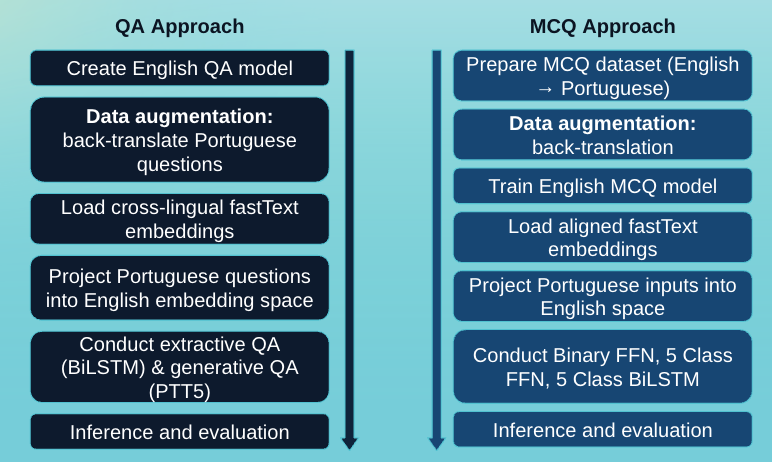

<a id="qa"></a>
# 7. QA Final Models

## Extractive QA with Cross-Lingual BiLSTM and fastText Projection

In our first modeling attempt, we designed an **extractive question answering model** to answer **Portuguese questions** using **English contexts**. The goal was to train a model capable of predicting the **start and end token indices** of the correct answer span within the English context, given a Portuguese input question.

### Model Architecture

We implemented a **bidirectional LSTM (BiLSTM)** for extractive QA, trained to predict the span of the answer using softmax over the token positions. The architecture includes:

* **Embedding dimension**: 300 (from pre-trained fastText vectors)
* **Hidden size**: 128
* **Layers**: 1 BiLSTM layer
* **Start/end heads**: Two fully connected linear layers on top of the BiLSTM hidden states
* **Loss function**: Cross-entropy loss on start and end indices
* **Optimizer**: Adam, learning rate 2e-4
* **Early stopping**: patience of 2 epochs

### Cross-Lingual Strategy

Since the questions are in Portuguese and the contexts are in English, we used a **projection-based method** to align them into a common semantic space:

1. **fastText embeddings**: Loaded English (`cc.en.300.vec`) and Portuguese (`cc.pt.300.vec`) word embeddings.
2. **Locally Linear Mapping (LLM)**: For each token in a Portuguese question, we projected it into English space by computing a weighted average of its top-5 nearest English neighbors.
3. **Input construction**: Each input sequence was formed as:
   `[projected Portuguese question] + [SEP token] + [English context]`,
   and fed into the BiLSTM as a sequence of 300-dimensional vectors.

### Data Preparation

We used the Pirá dataset (backtranslated variant), specifically:

* `context`: English text
* `bt_question`: Portuguese question, backtranslated for variation
* `answer`: English answer
* `answer_start`: computed using string matching to ensure extractiveness

We filtered examples where the answer string could be located within the context using exact string matching. However, this did not guarantee that the answer was a semantically appropriate span for the question. Many matches were partial, vague, or contextually incomplete. This inconsistency limited the effectiveness of our extractive QA model, despite technical compatibility with span-based supervision.

Final dataset sizes:

* **Train**: 124 aligned examples
* **Validation**: 17 examples
* **Test**: 17 examples

In [ ]:
!pip install --upgrade --force-reinstall numpy gensim

# Restart the kernel after this!

In [ ]:
# Re-import everything after restarting the kernel!

import pandas as pd
import os
from datasets import Dataset
from transformers import AutoTokenizer
import gc
import psutil
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter
from unidecode import unidecode
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from wordcloud import WordCloud, STOPWORDS
import string
import deepl

from transformers import MarianMTModel, MarianTokenizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from gensim.models import KeyedVectors
from sklearn.neighbors import NearestNeighbors
import evaluate


from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    Trainer, TrainingArguments
)

from transformers import pipeline

In [ ]:
# Download English and Portuguese fastText embeddings (300-dimensional)
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.vec.gz

# Unzip them
!gunzip cc.en.300.vec.gz
!gunzip cc.pt.300.vec.gz

!pip install --upgrade numpy gensim

import gensim

# Load English embeddings
en_embeddings = gensim.models.KeyedVectors.load_word2vec_format("cc.en.300.vec", binary=False)

# Load Portuguese embeddings
pt_embeddings = gensim.models.KeyedVectors.load_word2vec_format("cc.pt.300.vec", binary=False)

en_embeddings.save("cc.en.300.kv")
pt_embeddings.save("cc.pt.300.kv")

In [ ]:
# Re-load the data after restarting the kernel!

qa_pt_train = pd.read_csv("qa_pt_train_backtranslated.csv")
qa_pt_val   = pd.read_csv("qa_pt_val_backtranslated.csv")
qa_pt_test  = pd.read_csv("qa_pt_test_backtranslated.csv")

# Load fastText embeddings
en_embeddings = KeyedVectors.load("cc.en.300.kv", mmap='r')
pt_embeddings = KeyedVectors.load("cc.pt.300.kv", mmap='r')

# kNN for PT → EN projection
english_vocab = list(en_embeddings.key_to_index.keys())
english_matrix = np.vstack([en_embeddings[word] for word in english_vocab[:50000]])
knn = NearestNeighbors(n_neighbors=5).fit(english_matrix)

In [ ]:
# Tokenization and projection utilities
def tokenize(text):
    return text.lower().split()

def embed_tokens(tokens, embeddings, dim=300):
    return np.array([embeddings[word] if word in embeddings else np.zeros(dim) for word in tokens])

def project_pt_question_to_en_space(pt_question):
    words = tokenize(pt_question)
    projected = []
    for word in words:
        if word not in pt_embeddings:
            continue
        pt_vec = pt_embeddings[word].reshape(1, -1)
        distances, indices = knn.kneighbors(pt_vec)
        neighbors = [english_vocab[i] for i in indices[0]]
        weights = 1 / (distances + 1e-6)
        weights /= weights.sum()
        vec = sum(weights[0][i] * en_embeddings[neighbors[i]] for i in range(len(neighbors)))
        projected.append(vec)
    return np.array(projected)

def char_to_token_indices(context, answer, answer_start):
    tokens = tokenize(context)
    current_char = 0
    start_token = end_token = None
    for i, token in enumerate(tokens):
        token_start = context.find(token, current_char)
        token_end = token_start + len(token)
        current_char = token_end
        if start_token is None and token_start <= answer_start < token_end:
            start_token = i
        if token_start < answer_start + len(answer) <= token_end:
            end_token = i
            break
    return start_token, end_token

def compute_answer_start(df):
    df = df.copy()
    answer_starts = []
    valid_rows = []

    for i, row in df.iterrows():
        context = str(row["context"])
        answer = str(row["answer"]).strip()
        start_idx = context.find(answer)
        if start_idx != -1 and context[start_idx:start_idx + len(answer)].strip() == answer:
            answer_starts.append(start_idx)
            valid_rows.append(i)

    df = df.loc[valid_rows].reset_index(drop=True)
    df["answer_start"] = answer_starts
    print(f"Found valid answer spans in {len(df)} rows.")
    return df

qa_pt_train = compute_answer_start(qa_pt_train)
qa_pt_val   = compute_answer_start(qa_pt_val)
qa_pt_test  = compute_answer_start(qa_pt_test)

# Preprocess QA datasets
def preprocess(df_slice):
    X, y_start, y_end = [], [], []
    for _, row in df_slice.iterrows():
        q_vecs = project_pt_question_to_en_space(row["bt_question"])
        if q_vecs.size == 0:
            continue  # Skip this sample if no valid projected question vectors

        c_vecs = embed_tokens(tokenize(row["context"]), en_embeddings)
        full_input = np.vstack([q_vecs, np.zeros((1, 300)), c_vecs])

        s_idx, e_idx = char_to_token_indices(row["context"], row["answer"], row["answer_start"])
        if s_idx is not None and e_idx is not None:
            X.append(full_input)
            y_start.append(len(q_vecs) + 1 + s_idx)
            y_end.append(len(q_vecs) + 1 + e_idx)
    return X, y_start, y_end

# Preprocess datasets
X_train, y_train_start, y_train_end = preprocess(qa_pt_train)
X_val, y_val_start, y_val_end = preprocess(qa_pt_val)
X_test, y_test_start, y_test_end = preprocess(qa_pt_test)

# Padding
max_len = max(max(len(x) for x in X_train), max(len(x) for x in X_val + X_test))
def pad_sequences(X, max_len):
    return np.array([np.pad(x, ((0, max_len - len(x)), (0, 0))) for x in X])

X_train_tensor = torch.tensor(pad_sequences(X_train, max_len), dtype=torch.float32)
y_train_start_tensor = torch.tensor(y_train_start, dtype=torch.long)
y_train_end_tensor = torch.tensor(y_train_end, dtype=torch.long)

X_val_tensor = torch.tensor(pad_sequences(X_val, max_len), dtype=torch.float32)
y_val_start_tensor = torch.tensor(y_val_start, dtype=torch.long)
y_val_end_tensor = torch.tensor(y_val_end, dtype=torch.long)

X_test_tensor = torch.tensor(pad_sequences(X_test, max_len), dtype=torch.float32)
y_test_start_tensor = torch.tensor(y_test_start, dtype=torch.long)
y_test_end_tensor = torch.tensor(y_test_end, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_start_tensor, y_train_end_tensor), batch_size=16, shuffle=True)

In [ ]:
# BiLSTM Model
class BiLSTM_QA(nn.Module):
    def __init__(self, embedding_dim=300, hidden_size=128):
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        self.fc_start = nn.Linear(hidden_size * 2, 1)
        self.fc_end = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc_start(lstm_out).squeeze(-1), self.fc_end(lstm_out).squeeze(-1)

# Instantiate model, loss, optimizer
model = BiLSTM_QA()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# Training params
best_val_loss = float("inf")
patience = 2
wait = 0
num_epochs = 20

# Track loss for plotting
train_losses = []
val_losses = []

# Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_x, batch_y_start, batch_y_end in train_loader:
        optimizer.zero_grad()
        start_logits, end_logits = model(batch_x)
        loss = criterion(start_logits, batch_y_start) + criterion(end_logits, batch_y_end)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_start_logits, val_end_logits = model(X_val_tensor)
        val_loss = criterion(val_start_logits, y_val_start_tensor) + criterion(val_end_logits, y_val_end_tensor)
        val_loss = val_loss.item()

    # Print + Log
    print(f"Epoch {epoch+1} — Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")
    train_losses.append(total_loss)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        best_model_state = model.state_dict()
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
    model.train()

# Load best model
model.load_state_dict(best_model_state)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("BiLSTM Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Training Curve Analysis

The figure above shows the training and validation loss curves for the BiLSTM extractive QA model over 20 epochs.

#### Key Observations

* **Training loss** steadily decreases from \~105 to \~80, indicating the model is fitting the training data.
* **Validation loss** initially improves (from \~13 to \~9.5) but begins to plateau around epoch 8.
* The validation loss does not begin to rise despite continued training.

#### Limitations

The most significant limitation in this extractive QA setup is the **small and constrained dataset**. After filtering for examples where the answer appeared verbatim in the context (a requirement for span-based supervision), only:

* **126 training examples**
* **17 validation examples**
* **17 test examples**

were retained across the full dataset.

This extremely limited sample size offers insufficient coverage of question types, linguistic variation, and contextual complexity. As a result:

* The model likely **memorizes superficial patterns** rather than learning generalizable alignment between questions and answer spans.
* The **validation loss plateaus early**, suggesting that the model reaches its learning ceiling within the first few epochs.
* Even when the answer is technically present in the context, its **location or phrasing may not form a clean extractive span**, weakening the connection between supervision and model objective.

In short, the combination of **limited quantity** and **noisy extractiveness** undermines the viability of extractive QA in this setting.

In [ ]:
# Load best model and evaluate on test
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    start_logits, end_logits = model(X_test_tensor)
    pred_start = torch.argmax(start_logits, dim=1).numpy()
    pred_end = torch.argmax(end_logits, dim=1).numpy()

print(f"\nFINAL TEST EVALUATION:")
print(f"Train examples aligned: {len(X_train)} / {len(qa_pt_train)}")
print(f"Val examples aligned: {len(X_val)} / {len(qa_pt_val)}")
print(f"Test examples aligned: {len(X_test)} / {len(qa_pt_test)}")

# Load metric
rouge = evaluate.load("rouge")

# Decode predicted answers
def decode_answer(context, question, start_idx, end_idx):
    context_tokens = tokenize(context)
    question_tokens = tokenize(question)
    offset = len(question_tokens) + 1  # [SEP]
    if start_idx >= offset and end_idx >= offset and start_idx <= end_idx:
        start = start_idx - offset
        end = end_idx - offset + 1
        return " ".join(context_tokens[start:end])
    return "[Invalid span]"

def compute_f1(pred, truth):
    pred_tokens = set(pred.lower().split())
    truth_tokens = set(truth.lower().split())
    common = pred_tokens & truth_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * (precision * recall) / (precision + recall)

def compute_em(pred, truth):
    return int(pred.strip().lower() == truth.strip().lower())

# Evaluate predictions
predictions = []
for i in range(len(qa_pt_test)):
    pred = decode_answer(
        qa_pt_test.iloc[i]["context"],
        qa_pt_test.iloc[i]["bt_question"],
        pred_start[i],
        pred_end[i]
    )
    predictions.append(pred)

references = qa_pt_test["answer"].astype(str).tolist()
qa_pt_test["predicted_answer"] = predictions

# Compute per-example ROUGE-L
rouge_l_scores = []
for pred, ref in zip(predictions, references):
    score = rouge.compute(predictions=[pred], references=[ref], use_stemmer=True)
    rouge_l_scores.append(score["rougeL"])
qa_pt_test["rougeL"] = rouge_l_scores

# Print results
print(f"\nROUGE-L (avg): {qa_pt_test['rougeL'].mean():.2%}")

# Show top and bottom 3
print("\nTOP PREDICTIONS (ROUGE-L):")
for _, row in qa_pt_test.sort_values("rougeL", ascending=False).head(3).iterrows():
    print(f"Q: {row['bt_question']}")
    print(f"T: {row['answer']}")
    print(f"P: {row['predicted_answer']}")
    print(f"ROUGE-L: {row['rougeL']:.2%}")
    print("-" * 60)

print("\nBOTTOM PREDICTIONS (ROUGE-L):")
for _, row in qa_pt_test.sort_values("rougeL").head(3).iterrows():
    print(f"Q: {row['bt_question']}")
    print(f"T: {row['answer']}")
    print(f"P: {row['predicted_answer']}")
    print(f"ROUGE-L: {row['rougeL']:.2%}")
    print("-" * 60)

f1_scores = []
em_scores = []

for pred, truth in zip(qa_pt_test["predicted_answer"], qa_pt_test["answer"]):
    f1_scores.append(compute_f1(pred, truth))
    em_scores.append(compute_em(pred, truth))

qa_pt_test["f1"] = f1_scores
qa_pt_test["exact_match"] = em_scores

print(f"F1 (avg): {qa_pt_test['f1'].mean():.2%}")
print(f"Exact Match (avg): {qa_pt_test['exact_match'].mean():.2%}")

### Evaluation Metrics

To assess our extractive QA model’s performance, we evaluated predictions on the test set using both **span-based decoding** and **semantic similarity metrics**:

* **ROUGE-L**: Captures phrase-level overlap by computing the longest common subsequence between predicted and reference answers.
* **F1 Score**: Measures token-level precision and recall between the predicted span and the gold answer.
* **Exact Match (EM)**: Indicates whether the predicted span exactly matches the reference answer.
* **Span Decoding**: Converts predicted start and end indices into a textual answer span from the context.

### Performance and Observations

Despite effective training loss convergence over 20 epochs, the model’s performance on the test set remained very weak:

| Metric            | Score |
| ----------------- | ----- |
| **ROUGE-L (avg)** | 3.48% |
| **F1 Score**      | 3.67% |
| **Exact Match**   | 0.00% |

Predictions commonly suffered from the following failure modes:

* **Trivial spans**: Outputs were often single stopwords or function words (e.g., “de”, “em”, “por”).
* **Invalid indices**: Several predictions returned `[Invalid span]` due to reversed or out-of-bound start/end positions.
* **Semantic mismatch**: Many predicted spans bore no meaningful relation to the question, despite superficial string overlap.

Even the best predictions barely surpassed **25–30% ROUGE-L**, with most clustering near zero. Notably, the highest scoring predictions tended to capture **lexical fragments** but not the full meaning of the reference answers.

#### Example Predictions

| Question                                                                               | Predicted Answer      | Ground Truth                                              | ROUGE-L |
| -------------------------------------------------------------------------------------- | --------------------- | --------------------------------------------------------- | ------- |
| "a localização do campo de albacora goe."                                              | "em meados de"        | "na bacia de campos."                                     | 28.57%  |
| "o que edison lobao, o ministro de energia, disse sobre a revisão da lei do petróleo?" | *long off-topic span* | "que as mudanças serão projetadas..."                     | 17.86%  |
| "do que é constituído o núcleo do sistema de produção eth-ipb?"                        | "de 27"               | "um tubo flexível de 6 id dedicado ao fluido de produção" | 9.52%   |
| "por que a produção de mariscos é impactada..."                                        | `[Invalid span]`      | "a acidificação não é distribuída uniformemente"          | 0.00%   |
| "quais empresas colaboraram com a petrobras..."                                        | "em"                  | "tronic, reda, pirelli..."                                | 0.00%   |

### Conclusion

While the model successfully minimized training loss, it failed to learn meaningful span extraction — largely due to **inherent weaknesses in the dataset**:

* Many answers are **not reliably extractive**, even when they appear as substrings.
* Answers are often **paraphrased, fragmented**, or spread across multiple sentences.
* The training set is **very small** (only 124 aligned examples), limiting generalization.

These results suggest that **extractive modeling is ill-suited** for this QA setup. Given the dataset's characteristics, we transitioned to a **generative QA framework**, which is better equipped to handle loosely aligned, free-form answer text without requiring rigid span boundaries.

## Generative QA with T5 Fine-Tuning on Backtranslated Portuguese Questions

Following the limitations of our extractive QA model, we transitioned to a **generative question answering approach**. This allowed the model to produce **fluent free-text answers** instead of relying on exact spans from the context — a better fit for the Pirá dataset, where many answers are paraphrased or distributed across multiple sentences.

### Model Architecture

We fine-tuned a **pretrained sequence-to-sequence model**, [`unicamp-dl/ptt5-base-portuguese-vocab`](https://huggingface.co/unicamp-dl/ptt5-base-portuguese-vocab), a T5 model specifically trained on **Portuguese corpora**. This model supports both comprehension of Portuguese questions and generation of answers in fluent Portuguese.

* **Base model**: `ptt5-base-portuguese-vocab`
* **Max input length**: 512 tokens
* **Max target length**: 64 tokens
* **Batch size**: 8
* **Epochs**: 5
* **Optimizer**: AdamW (via Hugging Face `Trainer`)
* **Loss**: Cross-entropy loss over generated tokens

Each training example was structured as:

```
Input:   question: <bt_question> context: <context>
Target:  <answer>
```

Where `bt_question` is the **backtranslated Portuguese question**, and `context` and `answer` remain in Portuguese as provided in the dataset.

### Data Preparation

We used backtranslated Portuguese QA data (`qa_pt_train_backtranslated.csv`, etc.) where:

* `bt_question`: paraphrased Portuguese questions (via MarianMT backtranslation)
* `context`: Portuguese (or translated-to-Portuguese) passages
* `answer`: short, fluently phrased answers in Portuguese

After filtering for completeness, the datasets were formatted and tokenized using the Hugging Face `datasets` and `transformers` libraries.

In [ ]:
# Load datasets
qa_pt_train = pd.read_csv("qa_pt_train_backtranslated.csv")
qa_pt_val   = pd.read_csv("qa_pt_val_backtranslated.csv")

# Build input → "question: ... context: ..." / output → "answer"
def format_for_t5(df):
    df = df.dropna(subset=["bt_question", "context", "answer"])
    df["input_text"] = df.apply(lambda row: f"question: {row['bt_question']} context: {row['context']}", axis=1)
    df["target_text"] = df["answer"].astype(str).str.strip()
    return df[["input_text", "target_text"]]

train_df = format_for_t5(qa_pt_train)
val_df   = format_for_t5(qa_pt_val)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset   = Dataset.from_pandas(val_df)

# Load T5 tokenizer and model
model_name = "unicamp-dl/ptt5-base-portuguese-vocab"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tokenize
def preprocess(example):
    model_inputs = tokenizer(example["input_text"], max_length=512, truncation=True, padding="max_length")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example["target_text"], max_length=64, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_dataset.map(preprocess, remove_columns=train_dataset.column_names)
tokenized_val   = val_dataset.map(preprocess, remove_columns=val_dataset.column_names)

# Training args
training_args = TrainingArguments(
    output_dir="./generative_qa_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-4,
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=1,
    save_steps=500,
    prediction_loss_only=True
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer
)

trainer.train()
model.save_pretrained("t5_qa_model")
tokenizer.save_pretrained("t5_qa_model")

# Extract loss history
train_logs = [log for log in trainer.state.log_history if "loss" in log and "eval_loss" not in log]
eval_logs  = [log for log in trainer.state.log_history if "eval_loss" in log]

train_loss_vals = [entry["loss"] for entry in train_logs]
eval_loss_vals  = [entry["eval_loss"] for entry in eval_logs]
train_steps     = [entry["step"] for entry in train_logs]
eval_steps      = [entry["step"] for entry in eval_logs]

In [ ]:
# Get final training loss (last entry in train logs)
final_train_loss = train_loss_vals[-1] if train_loss_vals else None

# Get final validation loss (last entry in eval logs)
if eval_loss_vals:
    final_val_loss = eval_loss_vals[-1]
else:
    # Fallback: evaluate manually if no eval loss was logged
    eval_result = trainer.evaluate()
    final_val_loss = eval_result.get("eval_loss", None)

# Print results
print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Loss: {final_val_loss}")

Our model's training loss decreased significantly, from an initial value of 8.06 at step 10 to a final training loss of 0.47, indicating that the model successfully learned to fit the training data over time.

The final validation loss is 0.63, which is higher than the training loss but not drastically so. This gap suggests some overfitting, but not severe — the model still generalizes reasonably to unseen data.

In [ ]:
qa_pipeline = pipeline("text2text-generation", model="t5_qa_model", tokenizer="t5_qa_model")

qa_pt_test = pd.read_csv("qa_pt_test_backtranslated.csv")

def format_input(row):
    return f"question: {row['bt_question']} context: {row['context']}"

qa_pt_test = qa_pt_test.dropna(subset=["bt_question", "context"])
qa_pt_test["input_text"] = qa_pt_test.apply(format_input, axis=1)

predictions = []
for text in qa_pt_test["input_text"]:
    pred = qa_pipeline(text, max_length=64, truncation=True)[0]["generated_text"]
    predictions.append(pred)

qa_pt_test["predicted_answer"] = predictions

In [ ]:
def compute_f1(pred, truth):
    pred_tokens = set(pred.lower().split())
    truth_tokens = set(truth.lower().split())
    common = pred_tokens & truth_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * (precision * recall) / (precision + recall)

qa_pt_test["true_answer"] = qa_pt_test["answer"].astype(str).str.strip()
qa_pt_test["f1"] = qa_pt_test.apply(lambda r: compute_f1(r["predicted_answer"], r["true_answer"]), axis=1)
qa_pt_test["exact_match"] = qa_pt_test.apply(lambda r: int(r["predicted_answer"].strip().lower() == r["true_answer"].lower()), axis=1)

print(f"\nExact Match: {qa_pt_test['exact_match'].mean():.2%}")
print(f"F1 Score: {qa_pt_test['f1'].mean():.2%}")

In [ ]:
# Show a few example predictions
for i, row in qa_pt_test.sample(5, random_state=42).iterrows():
    print(f"1) Question: {row['bt_question']}")
    print(f"2) Context: {row['context'][:300]}...")  # Trim long contexts
    print(f"3) True Answer: {row['answer']}")
    print(f"4) Predicted Answer: {row['predicted_answer']}")
    print(f"5)F1: {row['f1']:.2f} | EM: {row['exact_match']}")
    print("-" * 80)

In [ ]:
rouge = evaluate.load("rouge")

references = qa_pt_test["answer"].astype(str).tolist()
predictions = qa_pt_test["predicted_answer"].astype(str).tolist()

rouge_results = rouge.compute(predictions=predictions, references=references)

print("\nROUGE Scores:")
for key, value in rouge_results.items():
    print(f"{key}: {value:.2%}")

# Compute per-example ROUGE-L
rouge_l_scores = []
for ref, pred in zip(references, predictions):
    score = rouge.compute(predictions=[pred], references=[ref], use_stemmer=True)
    rouge_l_scores.append(score["rougeL"])

qa_pt_test["rougeL"] = rouge_l_scores

In [ ]:
# Best 5
print("Best ROUGE-L Predictions:\n")
for _, row in qa_pt_test.sort_values("rougeL", ascending=False).head(5).iterrows():
    print(f"1) Q: {row['bt_question']}")
    print(f"2) Context: {row['context'][:200]}...")
    print(f"3) True: {row['answer']}")
    print(f"4) Pred: {row['predicted_answer']}")
    print(f"5) ROUGE-L: {row['rougeL']:.2%}")
    print("-" * 80)

# Worst 5
print("Worst ROUGE-L Predictions:\n")
for _, row in qa_pt_test.sort_values("rougeL", ascending=True).head(5).iterrows():
    print(f"1) Q: {row['bt_question']}")
    print(f"2) Context: {row['context'][:200]}...")
    print(f"3) True: {row['answer']}")
    print(f"4) Pred: {row['predicted_answer']}")
    print(f"5) ROUGE-L: {row['rougeL']:.2%}")
    print("-" * 80)

### Evaluation Metrics

Since the task is **generative**, we evaluated performance using metrics suitable for free-text generation:

* **Exact Match (EM)**: Percentage of predictions that exactly match the gold answer.
* **F1 Score**: Token-level precision and recall between prediction and reference.
* **ROUGE-L**: Measures the longest common subsequence between prediction and reference, capturing sequence-level overlap.

### Evaluation Results

| Metric        | Value      |
| ------------- | ---------- |
| Exact Match   | **1.85%**  |
| F1 Score      | **28.44%** |
| ROUGE-L (avg) | **31.98%** |

While **Exact Match remains low**, this is expected in generative QA, especially when answers are paraphrased. The **F1** and **ROUGE-L scores** indicate that the model often produces **semantically appropriate answers** with moderate surface-level overlap.

### Prediction Examples

#### Good Prediction (High F1 and ROUGE)

> **Question**: "Qual é o impacto na praia da barreira de segurança?"
> **Gold**: "Falha pode iniciar imediatamente eventos de ganhos e perdas no poço..."
> **Predicted**: "A falha pode iniciar imediatamente os eventos de ganhos e perdas no poço..."
> → **F1**: 0.92 | **ROUGE-L**: High

#### Poor Prediction (Low F1/ROUGE despite semantic relevance)

> **Question**: "Onde o navio Skandi Aker opera?"
> **Gold**: "Primariamente nas águas profundas"
> **Predicted**: "Na bacia de águas profundas."
> → **F1**: 0.00 | **ROUGE-L**: 0.00

### Additional Examples

#### **Better Generations**

* **Q**: "Quando foi instalada a primeira bomba submersível elétrica?"
  
  **A**: "Outubro/1994" → ✔ Predicted **exactly**, ROUGE-L: **100%**

* **Q**: "Onde encontro *Amphisbaena pretrei*?"
  
  **A**: "Leste do Brasil" → ✔ Predicted **exactly**, ROUGE-L: **100%**

* **Q**: "Quem enviou a carta à empresa americana Global Industries?"
  
  **A**: "Petrobras" → ✔ Predicted **exactly**, ROUGE-L: **100%**

#### **Failure Cases (ROUGE-L: 0.00%)**

* **Q**: "De que forma as imagens das ondas são impactadas por mudanças críticas?"
  
  **A**: "Mudanças climáticas devem resultar em aumentos expressivos..."
  
  **Pred**: "A elevação do nível do mar (SLR)"

* **Q**: "Onde os campos de petróleo offshore estão sendo desenvolvidos?"
  
  **A**: "Em grandes profundidades"
  
  **Pred**: "Na bacia de Campos, Brasil"

### Insights and Takeaways

* The model generates **fluent and context-aware Portuguese answers**, even from limited training data.
* It handles **structured factual questions** well, especially when answers are short or named entities.
* Most errors occur when predictions are **vague, generic**, or **contextually plausible but not extractive**.
* **ROUGE-L and F1 capture partial correctness**, even when EM is zero — especially helpful in paraphrastic cases.

> **Note on Metrics**: While F1 and Exact Match are traditionally used in extractive QA, they have limitations in the **generative setting**. Many valid answers differ in surface form but are semantically correct. As a result:
>
> * **Exact Match** often underestimates performance.
> * **F1 Score** may still reflect token-level overlap, but misses meaning-level fidelity.
> * **ROUGE-L** tends to be more informative, capturing sequence-level similarity even when word order varies.

Overall, the results confirm that a **generative QA model is better suited** to this task than an extractive one, especially given the **paraphrased, non-verbatim nature** of many ground-truth answers in the Pirá dataset.

<a id="mcq"></a>
# 8. MCQ Final Model

The multilingual MCQ system answers Portuguese multiple-choice questions over English contexts using cross-lingual projection. Since the MCQ dataset is originally in English, translation steps are required.

**Step 1: Prepare the MCQ dataset.**

Each entry includes an English context (text), question (question), answer options (A, B, C, D, optionally E), and the correct answer label. If Portuguese inputs are needed, questions and options must be translated.

**Step 2: Back-translate Portuguese questions and options.**

Translate questions and options into English and back into Portuguese using MarianMT to generate paraphrased inputs.

**Step 3: Train the English MCQ model.**

Train a model to classify the correct answer among options.

**Step 4: Load aligned fastText embeddings.**

Use aligned English and Portuguese embeddings to allow cross-lingual projection.

**Step 5: Project Portuguese inputs into English space.**

Project Portuguese questions and options into the English-trained MCQ model's embedding space. Only project the question and options — the context remains in English.

**Step 6: Inference and scoring.**

Tokenize the English context with each projected Portuguese question-option pair. Score each pairing using the MCQ model and select the highest-scoring option as the final prediction. Outputs can be the predicted letter (A/B/C/D) or the corresponding English/Portuguese text.

In [ ]:
# Step 1: Creating the Backtranslated Multiple Choice.
# Saved these as csv files for better access and prevent redundant computations

# === Paths ===
base_path  = "/content/drive/My Drive/Project/Milestone 4/"
output_dir = "/content/drive/My Drive/Project/Milestone 5/backtranslations/"

os.makedirs(output_dir, exist_ok=True)
model_name_en_pt = "Helsinki-NLP/opus-mt-tc-big-en-pt"
tokenizer_en_pt = MarianTokenizer.from_pretrained(model_name_en_pt)
model_en_pt     = MarianMTModel.from_pretrained(model_name_en_pt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_en_pt.to(device)

# === Helper to translate a list of strings EN→PT ===
def translate_en_to_pt(texts, batch_size=16):
    translations = []
    model_en_pt.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Translating EN→PT"):
            batch = texts[i : i + batch_size]
            enc = tokenizer_en_pt(batch, return_tensors="pt", padding=True, truncation=True).to(device)
            outs = model_en_pt.generate(**enc)
            translations.extend(tokenizer_en_pt.batch_decode(outs, skip_special_tokens=True))
    return translations

# === One‐shot PT option–translation for a split ===
def translate_mcq_options_to_pt(in_csv, out_csv):
    # skip if already done
    if os.path.exists(out_csv):
        print(f"{out_csv} exists; loading.")
        return pd.read_csv(out_csv)

    print(f"\n Reading {in_csv}")
    df = pd.read_csv(in_csv)
    # parse the “options” column into lists
    df["options"] = df["options"].apply(eval)

    # flatten and translate
    flat_opts = [opt for opts in df["options"] for opt in opts]
    print(f"\n Translating {len(flat_opts)} option‐strings EN→PT")
    pt_opts = translate_en_to_pt(flat_opts, batch_size=16)

    # regroup into rows
    lengths = df["options"].apply(len).tolist()
    grouped = []
    idx = 0
    for L in lengths:
        grouped.append(pt_opts[idx : idx + L])
        idx += L

    df["bt_options"] = grouped

    # keep only the columns you want
    cols = [
        "id",
        "context",
        "question",
        "options",
        "correct_option",
        "correct_answer_text",
        "question_pt_deepl",
        "bt_options",
    ]
    df = df[[c for c in cols if c in df.columns]]

    print(f"\n Saving {out_csv}")
    df.to_csv(out_csv, index=False)
    return df

train_in  = base_path + "processed_mcqa_train.csv"
val_in    = base_path + "processed_mcqa_validation.csv"
test_in   = base_path + "processed_mcqa_test.csv"

train_out = output_dir + "mcqa_train_pt_options.csv"
val_out   = output_dir + "mcqa_val_pt_options.csv"
test_out  = output_dir + "mcqa_test_pt_options.csv"


In [ ]:
# NOTE: These only need to be run once if the files are not in the drive.
# Else, skip to Reading the Backtranslation files

mcqa_train = translate_mcq_options_to_pt(train_in, train_out)

In [ ]:
# torch.cuda.empty_cache()
mcqa_val   = translate_mcq_options_to_pt(val_in, val_out)

In [ ]:
# torch.cuda.empty_cache()
mcqa_test  = translate_mcq_options_to_pt(test_in, test_out)

In [ ]:
# Reading the Backtranslation files

base_dir = "/content/drive/My Drive/Project/Milestone 5/backtranslations/"

train_df = pd.read_csv(base_dir + "mcqa_train_pt_options.csv")
val_df   = pd.read_csv(base_dir + "mcqa_val_pt_options.csv")
test_df  = pd.read_csv(base_dir + "mcqa_test_pt_options.csv")

# Parse the bt_options column back to lists
for df in [train_df, val_df, test_df]:
    df["bt_options"] = df["bt_options"].apply(eval)

In [ ]:
en_embeddings = KeyedVectors.load_word2vec_format("cc.en.300.vec", binary=False)
pt_embeddings = KeyedVectors.load_word2vec_format("cc.pt.300.vec", binary=False)


In [ ]:
# Build kNN for English embedding space
english_vocab = list(en_embeddings.key_to_index.keys())
english_matrix = np.vstack([en_embeddings[word] for word in english_vocab[:50000]])
knn = NearestNeighbors(n_neighbors=5).fit(english_matrix)


In [ ]:
# Step 4: Define Projection and Embedding Functions
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-zá-úà-ùãõâêîôûç0-9 ]", " ", text)  # keep alphanumerics + accents
    text = re.sub(r"\s+", " ", text).strip()
    return text.split()

def embed_tokens(tokens, embeddings, dim=300):
    return np.array([embeddings[word] if word in embeddings else np.zeros(dim) for word in tokens])


In [ ]:
def project_to_en_space(pt_text):
    words = tokenize(pt_text)
    projected = []
    for word in words:
        if word not in pt_embeddings:
            continue
        pt_vec = pt_embeddings[word].reshape(1, -1)
        distances, indices = knn.kneighbors(pt_vec)
        neighbors = [english_vocab[i] for i in indices[0]]
        weights = 1 / (distances + 1e-6)
        weights /= weights.sum()
        vec = sum(weights[0][i] * en_embeddings[neighbors[i]] for i in range(len(neighbors)))
        projected.append(vec)

    # Debug: warn if empty
    if len(projected) == 0:
        print(f"Empty projection for text: '{pt_text[:50]}...'")
    return np.array(projected)

# Binary Classification Approach
We initially  implemented a **binary classification approach** for multiple-choice QA by defining the `MCQDataset` class. Each Portuguese question and its five answer options are projected into the English embedding space, and then paired to form five (question, option) combinations per question. Each pair is labeled with a binary value: 1 if the option is the correct answer, and 0 otherwise.

The code includes checks to skip samples where either the question or any option fails to project into the embedding space, and prints error messages for invalid labels or projection issues to ensure only valid training examples are retained. If an option fails to project (i.e., results in an empty vector after applying `project_to_en_space`), the entire multiple-choice question is skipped during dataset construction. This prevents errors during training (like shape mismatches) and ensures the model only learns from complete and valid input pairs.




In [ ]:
class MCQDataset(Dataset):
    def __init__(self, dataframe, max_len=100):
        self.samples = []
        self.labels = []
        self.max_len = max_len
        skipped_rows = 0

        for idx, row in dataframe.iterrows():
            q_proj = project_to_en_space(row["question_pt_deepl"])
            opt_proj_list = [project_to_en_space(opt) for opt in row["bt_options"]]

            # Skip if question or any option projection is empty
            if q_proj.shape[0] == 0 or any(opt.shape[0] == 0 for opt in opt_proj_list):
                skipped_rows += 1
                continue

            try:
                correct_idx = ord(row["correct_answer_text"].strip().lower()) - ord('a')
            except Exception as e:
                print(f" Invalid correct_answer_text at row {idx}: {e}")
                skipped_rows += 1
                continue

            for i, opt_proj in enumerate(opt_proj_list):
                try:
                    seq = np.vstack([q_proj, opt_proj])  # Shape: (T, 300)
                except ValueError as e:
                    print(f" vstack error at row {idx}, option {i}: {e}")
                    skipped_rows += 1
                    continue

                if len(seq) > self.max_len:
                    seq = seq[:self.max_len]
                else:
                    seq = np.pad(seq, ((0, self.max_len - len(seq)), (0, 0)))  # Pad to (max_len, 300)

                self.samples.append(seq)
                self.labels.append(1 if i == correct_idx else 0)

        if skipped_rows > 0:
            print(f"⚠️ Skipped {skipped_rows} rows due to empty projections or errors.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.long)
        )

### **FFNN Softmax MCQ Classifier**

As a baseline, we used a feedforward neural network to classify MCQ options. The FFNN computes a score for each option paired with the question. It ignores word order and computes a mean vector over the sequence before classification.

* **Embedding dimension**: 300 (from fastText projections)
* **Hidden size**: 128
* **Layers**: Two linear layers with ReLU and dropout
* **Dropout**: 0.3 after the first layer
* **Loss function**: Binary cross-entropy (1 for correct option, 0 otherwise)
* **Optimizer**: Adam, learning rate 2e-4
* **Input shape**: `[batch_size, sequence_length, 300]` (reduced to mean vector)
* **Output**: Scalar logit per question–option pair

In [ ]:
# Softmax Classifier
class SoftmaxFFN_MCQ(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        mean_vec = torch.mean(x, dim=1)
        h = F.relu(self.fc1(mean_vec))
        h = self.dropout(h)
        return self.fc2(h).squeeze(-1)

We train the MCQ  classification model with the binary cross-entropy loss, tracking training and validation performance across epochs to return the best-performing model state based on validation loss. Lastly the function also plots the loss curves.


In [ ]:
def train_mcq_model(model, train_dataset, val_dataset, model_name="MCQ_Model", num_epochs=20, lr=2e-4, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.float().to(device)
            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.float().to(device)
                logits = model(x_batch)
                loss = criterion(logits, y_batch)
                val_loss += loss.item()

                preds = torch.sigmoid(logits).cpu().numpy() > 0.5
                all_preds.extend(preds)
                all_labels.extend(y_batch.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Acc: {acc:.2%} | F1: {f1:.2%}")

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = model.state_dict()

    # Plot training/validation loss
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model_state

In [ ]:
train_dataset = MCQDataset(train_df, max_len=100)

In [ ]:
val_dataset   = MCQDataset(val_df, max_len=100)

In [ ]:
test_dataset   = MCQDataset(test_df, max_len=100)

When letters and numbers are next to each other, there is an empty projection. This can be ignored.

In [ ]:
# MCQ using Softmax
softmax_model = SoftmaxFFN_MCQ(input_dim=300, hidden_dim=128)
best_softmax_state = train_mcq_model(softmax_model, train_dataset, val_dataset, model_name="SoftmaxFFN_MCQ")


The SoftmaxFFN\_MCQ model initially shows promising training and validation loss curves, both decreasing and stabilizing around 0.49, suggesting early learning. However, its 80% accuracy is misleading due to class imbalance—each MCQ generates five pairs (one correct, four incorrect), meaning 80% of labels are zero. The model appears to always predict the negative class, achieving high accuracy by rejecting all options but failing to select the correct one. This is confirmed by the 0% F1 score, indicating no successful positive predictions. As a result, binary classification fails to capture what we actually want: choosing the correct answer per question. A switch to 5-class classification is necessary.

In [ ]:
def evaluate_mcq_model(model, dataset, model_state):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(model_state)
    model.to(device)
    model.eval()

    loader = DataLoader(dataset, batch_size=32)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)
            preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"\nEvaluation Results:")
    print(f"Accuracy:  {acc:.2%}")
    print(f"F1 Score:  {f1:.2%}")

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Correct", "Correct"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix (Binary MCQ Classifier)")
    plt.grid(False)
    plt.show()


evaluate_mcq_model(softmax_model, test_dataset, best_softmax_state)

The confusion matrix confirms what we discussed above: there are no successful positive predictions, and the binary classifcation failes to choose the correct answer for each question. We proceed with moving to a 5-class classification.

# MCQ 5 Class Classification Approach
To improve accuracy, we turned the binary classification into a 5-class multiple-choice QA. For each question, it projects the Portuguese question and all five answer options into English embedding space, stacks each (question + option) pair into a sequence, and labels the correct option’s index (0–4). Each sample is stored as a tensor of shape `(5, max_len, 300)` with a single integer label.

Just like the binary classification, this code includes checks to skip samples where either the question or any option fails to project into the embedding space, and prints error messages for invalid labels or projection issues to ensure only valid training examples are retained.

Because the 5-class setup treats MCQ as a single classification task per question (rather than scoring individual options), the training and evaluation functions use cross-entropy loss and `argmax` over option scores instead of binary labels and sigmoid thresholds. This allows the model to directly learn to select the most likely correct option out of five.



In [ ]:
class MCQ5ClassDataset(Dataset):
    def __init__(self, dataframe, max_len=100):
        self.samples = []
        self.labels = []
        self.max_len = max_len
        skipped = 0

        for idx, row in dataframe.iterrows():
            q_proj = project_to_en_space(row["question_pt_deepl"])
            opt_proj_list = [project_to_en_space(opt) for opt in row["bt_options"]]

            if q_proj.shape[0] == 0 or any(opt.shape[0] == 0 for opt in opt_proj_list):
                skipped += 1
                continue

            try:
                correct_idx = ord(row["correct_answer_text"].strip().lower()) - ord('a')
                if not (0 <= correct_idx < len(opt_proj_list)):
                    raise ValueError("Index out of range")
            except Exception as e:
                print(f" Invalid correct_answer_text at row {idx}: {e}")
                skipped += 1
                continue

            stacked = []
            for opt_vec in opt_proj_list:
                seq = np.vstack([q_proj, opt_vec])
                if len(seq) > self.max_len:
                    seq = seq[:self.max_len]
                else:
                    seq = np.pad(seq, ((0, self.max_len - len(seq)), (0, 0)))
                stacked.append(seq)

            self.samples.append(np.stack(stacked))  # shape: (5, max_len, 300)
            self.labels.append(correct_idx)

        if skipped:
            print(f" Skipped {skipped} rows due to projection issues.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.samples[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.long)
        )


def train_mcq_5class_model(model, train_dataset, val_dataset, model_name="MCQ_5Class_Model", num_epochs=20, lr=2e-4, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # Validation loop
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                logits = model(x_batch)
                loss = criterion(logits, y_batch)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(y_batch.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average="macro")
        print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Acc: {acc:.2%} | F1: {f1:.2%}")

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = model.state_dict()

    # Plot training/validation loss
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model_state


In [ ]:
train_dataset_5c =  MCQ5ClassDataset(train_df, max_len=100)
val_dataset_5c   = MCQ5ClassDataset(val_df, max_len=100)
test_dataset_5c   = MCQ5ClassDataset(test_df, max_len=100)

We decide to implement both a Softmax FFN and a BiLSTM classifier to compare their performances.

### Softmax FFN MCQ Classifier (5-Class)

For the 5-class MCQ task, we implemented a feedforward neural network that computes a score for each of the five answer options, given a projected Portuguese question. Each option is processed independently by averaging its token embeddings with the question and passing the result through two dense layers. The model does not consider token order but captures overall semantic similarity.

* **Embedding dimension:** 300 (from fastText projections)
* **Hidden size:** 128
* **Layers:** Two linear layers with ReLU activation and dropout
* **Dropout:** 0.3 after the first layer
* **Loss function:** Cross-entropy over 5 classes (one-hot correct answer)
* **Optimizer:** Adam, learning rate 2e-4
* **Input shape:** \[batch\_size, 5, sequence\_length, 300]
* **Output:** \[batch\_size, 5] logits (one per option, softmax applied during training)

---

### BiLSTM MCQ Classifier (5-Class)

To better capture sequential patterns in projected question–option pairs, we implemented a BiLSTM-based classifier for the 5-class setup. Unlike the FNN, this model considers the order of tokens, encoding each (question + option) sequence using a bidirectional LSTM. A mean pooling is applied to the LSTM outputs, and each pooled vector is scored to select the correct option.

* **Embedding dimension:** 300 (from fastText projections)
* **Hidden size:** 128
* **Layers:** One BiLSTM layer followed by a linear classifier
* **Loss function:** Cross-entropy over 5 options
* **Optimizer:** Adam, learning rate 2e-4
* **Input shape:** \[batch\_size, 5, sequence\_length, 300]
* **Output:** \[batch\_size, 5] logits (one per option, softmax during training)

The BiLSTM model is introduced here (unlike in binary classification) to help the model differentiate between closely competing options using word sequence information.


In [ ]:
# 5-Class MCQ Models (SoftmaxFFN and BiLSTM)
class SoftmaxFFN_MCQ5(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):  # x: (batch_size, 5, seq_len, input_dim)
        scores = []
        for i in range(5):
            opt_vec = x[:, i, :, :]  # (batch, seq_len, input_dim)
            mean_vec = torch.mean(opt_vec, dim=1)
            h = F.relu(self.fc1(mean_vec))
            h = self.dropout(h)
            score = self.fc2(h).squeeze(-1)
            scores.append(score)
        return torch.stack(scores, dim=1)  # (batch, 5)

class BiLSTM_MCQ5(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):  # x: (batch_size, 5, seq_len, input_dim)
        scores = []
        for i in range(5):
            opt_vec = x[:, i, :, :]  # (batch, seq_len, input_dim)
            lstm_out, _ = self.lstm(opt_vec)
            pooled = torch.mean(lstm_out, dim=1)
            score = self.fc(pooled).squeeze(-1)
            scores.append(score)
        return torch.stack(scores, dim=1)  # (batch, 5)

In [ ]:
# Train Softmax FFN Model
softmax_model_5c = SoftmaxFFN_MCQ5(input_dim=300, hidden_dim=128)
best_softmax_state_5c = train_mcq_5class_model(
    softmax_model_5c, train_dataset_5c, val_dataset_5c, model_name="SoftmaxFFN_MCQ5"
)


The model begins with a loss near 1.61, reflecting a value for random guessing in a 5-class task. This only declines to 1.58—indicating minimal learning. As accuracy stays around around 33% this suggests limited improvement from weak inputs, underfitting, or noisy projections.


In [ ]:
# Train BiLSTM Model
bilstm_model_5c = BiLSTM_MCQ5(input_dim=300, hidden_dim=128)
best_bilstm_state_5c = train_mcq_5class_model(
    bilstm_model_5c, train_dataset_5c, val_dataset_5c, model_name="BiLSTM_MCQ5"
)

For the BiLSTM 5 class classification, we can see that the validation loss settles between roughly 1.52 to 1.54, first reaching that point after just 3 epochs. These results are not much different from the FFN loss and accuracy. We still start at random guessing and eventually reach an accuracy in the low 30% range. This confirms that our models are learning slightly past the random guessing benchmark, but they are still predicting incorrectly on over two-thirds of the questions. There is still significant room for improvement.

In [ ]:
def evaluate_mcq_5class_model(model, dataset, model_state):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(model_state)
    model.to(device)
    model.eval()

    loader = DataLoader(dataset, batch_size=32)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Test Accuracy: {acc:.2%}")
    print(f"Test F1 Score: {f1:.2%}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3, 4])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix (5-Class MCQ)")
    plt.show()


## 5-Class Softmax FFN evaluation

In [ ]:
evaluate_mcq_5class_model(softmax_model_5c, test_dataset_5c, best_softmax_state_5c)

The confusion matrix for the BiLSTM 5 class classification tells a similar story to the Softmax FFN. Interestingly, we once again see that answer choices 'C' and 'D' have the highest counts of correct classifications. This is worth taking a note of, and a sign that randomly permuting the answer choices could be a beneficial step in the data pre-processing stage. These two answer choices actually seem to compensate for the accuracy of the other answer choices, but not significantly.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained weights and set to eval
softmax_model_5c.load_state_dict(best_softmax_state_5c)
softmax_model_5c.to(device)
softmax_model_5c.eval()

print("Softmax FFN 5-Class — Sample Predictions:\n")
for idx in sample(range(len(val_df)), 5):
    row = val_df.iloc[idx]

    # Project question and options
    q_vec = project_to_en_space(row["question_pt_deepl"])
    opt_vecs = [project_to_en_space(opt) for opt in row["bt_options"]]

    if q_vec.shape[0] == 0 or any(opt.shape[0] == 0 for opt in opt_vecs):
        print("Skipping due to empty projection.\n")
        continue

    max_len = 100
    pairs = []
    for opt_vec in opt_vecs:
        pair = np.vstack([q_vec, opt_vec])
        if len(pair) > max_len:
            pair = pair[:max_len]
        else:
            pair = np.pad(pair, ((0, max_len - len(pair)), (0, 0)))
        pairs.append(pair)

    # Fix: Add batch dimension
    x_batch = torch.tensor(np.stack(pairs), dtype=torch.float32).unsqueeze(0).to(device)  # shape: (1, 5, seq_len, 300)

    with torch.no_grad():
        logits = softmax_model_5c(x_batch)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = int(np.argmax(probs))

    correct_idx = ord(row["correct_answer_text"].strip().lower()) - ord("a")
    pred_letter = chr(ord("a") + pred_idx)
    correct_letter = chr(ord("a") + correct_idx)

    print(f"Question (PT): {row['question_pt_deepl']}")
    print(f"Question (EN): {row['question']}\n")

    for i, (pt_opt, en_opt) in enumerate(zip(row["bt_options"], eval(row["options"]))):
        if i == correct_idx and i == pred_idx:
            marker = "[CORRECT | PREDICTED]"
        elif i == correct_idx:
            marker = "[CORRECT]"
        elif i == pred_idx:
            marker = "[PREDICTED]"
        else:
            marker = ""
        print(f"{marker:<20} {chr(ord('a') + i)}) PT: {pt_opt}")
        print(f"{'':<20}     EN: {en_opt}")

    print(f"\nPredicted: {pred_letter} | Correct: {correct_letter}")
    print("-" * 80)



## 5-Class BiLTSM Classification

In [ ]:
evaluate_mcq_5class_model(bilstm_model_5c, test_dataset_5c, best_bilstm_state_5c)

The confusion matrix for the BiLSTM 5 class classification tells a similar story to the Softmax FFN. Interestingly, we once again see that answer choices 'C' and 'D' have the highest counts of correct classifications. This is worth taking a note of, and a sign that randomly permuting the answer choices could be a beneficial step in the data pre-processing stage. These two answer choices actually seem to compensate for the accuracy of the other answer choices, but not significantly.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load best model weights and prepare model
bilstm_model_5c.load_state_dict(best_bilstm_state_5c)
bilstm_model_5c.to(device)
bilstm_model_5c.eval()

print("BiLSTM 5-Class — Sample Predictions:\n")
for idx in sample(range(len(val_df)), 5):
    row = val_df.iloc[idx]

    # Project question and options
    q_vec = project_to_en_space(row["question_pt_deepl"])
    opt_vecs = [project_to_en_space(opt) for opt in row["bt_options"]]

    if q_vec.shape[0] == 0 or any(opt.shape[0] == 0 for opt in opt_vecs):
        print("Skipping due to empty projection.\n")
        continue

    # Stack [Q;Opt] for each option
    max_len = 100
    pairs = []
    for opt_vec in opt_vecs:
        pair = np.vstack([q_vec, opt_vec])
        if len(pair) > max_len:
            pair = pair[:max_len]
        else:
            pair = np.pad(pair, ((0, max_len - len(pair)), (0, 0)))
        pairs.append(pair)

    # Add batch dimension: (1, 5, seq_len, 300)
    x_batch = torch.tensor(np.stack(pairs), dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = bilstm_model_5c(x_batch)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = int(np.argmax(probs))

    correct_idx = ord(row["correct_answer_text"].strip().lower()) - ord("a")
    pred_letter = chr(ord("a") + pred_idx)
    correct_letter = chr(ord("a") + correct_idx)

    print(f"Question (PT): {row['question_pt_deepl']}")
    print(f"Question (EN): {row['question']}\n")

    for i, (pt_opt, en_opt) in enumerate(zip(row["bt_options"], eval(row["options"]))):
        if i == correct_idx and i == pred_idx:
            marker = "[CORRECT | PREDICTED]"
        elif i == correct_idx:
            marker = "[CORRECT]"
        elif i == pred_idx:
            marker = "[PREDICTED]"
        else:
            marker = ""
        print(f"{marker:<20} {chr(ord('a') + i)}) PT: {pt_opt}")
        print(f"{'':<20}     EN: {en_opt}")

    print(f"\nPredicted: {pred_letter} | Correct: {correct_letter}")
    print("-" * 80)



<a id="conclusion"></a>
# 9. Conclusion

The MCQ and QA models are difficult to compare directly since they are used for different tasks, however we can see that in both cases, they offered an improvement on each task over the baseline model.

On the QA dataset, the baseline model had an exact match of 0% and a ROUGE-L score of 0.0854. While the Extractive model also had an exact match of 0%, it offered an improvement on the ROUGE-L score with a score of 3.48%. Generative QA model yielded better results than the Extractive QA model, with an exact match of 1.85% and a ROUGE-L score of 31.98%. It therefore seems that the Extractive QA model was a lot better suited for the task and dataset. Although the exact match stayed low (which is expected given the variable nature of language), the model was able to capture notions of semantic correctness in a multilingual setting.

The MCQA baseline model performed binary classification with an accuracy of 0.8. Despite the seemingly high accuracy, we find that this is because the model is predicting all predictions to be 0, which is true 80% of the time. We find similar results with the Binary FFN Classifier which also has an accuracy of 80% and yielded and F1 score of 0%. Following this, we moved to a 5-class classification which evaluates  whether the model correctly selects the single correct answer out of five choices. We trained both a Softmax FFN and a BiLSTM. The Softmax FFN achieved an accuracy of 30.97% and an F1 score of 30.53%. The BiLSTM had an accuracy had an accuracy of 31.86% and an F1 score of 31.31%. Both models showed an improvement from the binary classifiers - changing the task to multi-class meant that they were no longer simply predicting the same class. This was also clear through an improvement in the F1 score. It appears that the BiLSTM had a slightly better performance than the Softmax FFN.

While the models offered an improvement over the baseline model, there could be further improvements made by addressing class imbalance and sample size. Despite our attempts at data augmentation using back-translation, the limited model performance made it is clear that this was not sufficient to supplement a lack of data.

## Future Directions

There are several future directions we can consider. The first is a more granular modeling approach, based on the class imbalances we saw specifically with question type and difficulty. Modeling separately or including this information directly may help us identify model strengths and weaknesses, and allow us to fine-tune in a more targeted manner.

Another future direction would be to expand to true multilingual settings (3 or more languages). This approach could lead to a more well-rounded and generalizable model, but would require more elaborate data processing and tokenization methods.

We acknowledge that the scope of this project is fairly narrow, as seen in our EDA, centered around topics such as Brazilian coastlines, oil, climate change, etc. To increase generalizability to other themes, we can start expanding the scope by slowly feeding our models a mix of relevant, tangentially relevant, and completely irrelevant content (in the form of context, questions, or options). The goal would be for our models to start gaining more inter-domain knowledge while also being able to discriminate against "distractors".

A technique that was central to our project was back-translations. One future approach is to incorporate contrastive learning with these translated pairs. This could help with the projections and increase the model performances.

Lastly, the original Pira study compared many models across various approaches. While we compared a couple, it could be worth exploring more models, especially with our back-translation approach. This could help us assess how models benefit or suffer with back-translations, and the effectiveness of the technique at large.